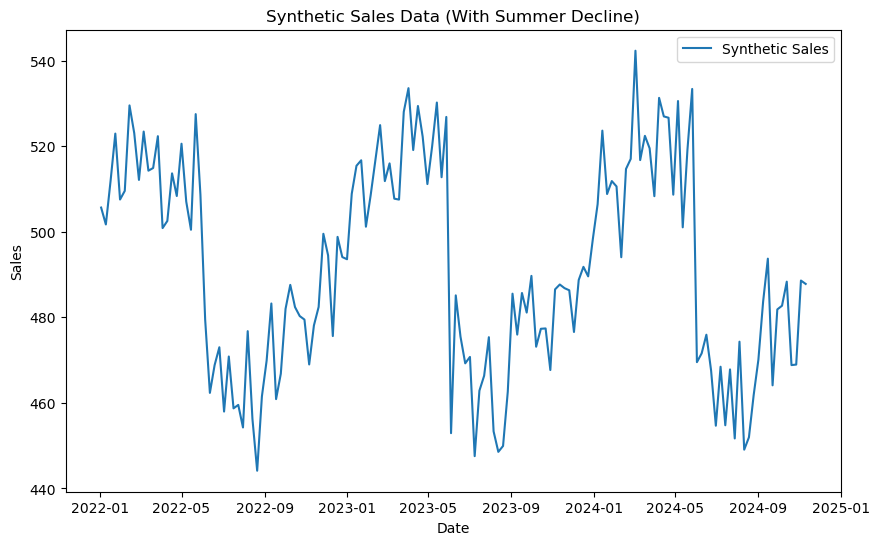

13:22:12 - cmdstanpy - INFO - Chain [1] start processing
13:22:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\sonam\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 20.825927607534137, RMSE: 26.163853797066572


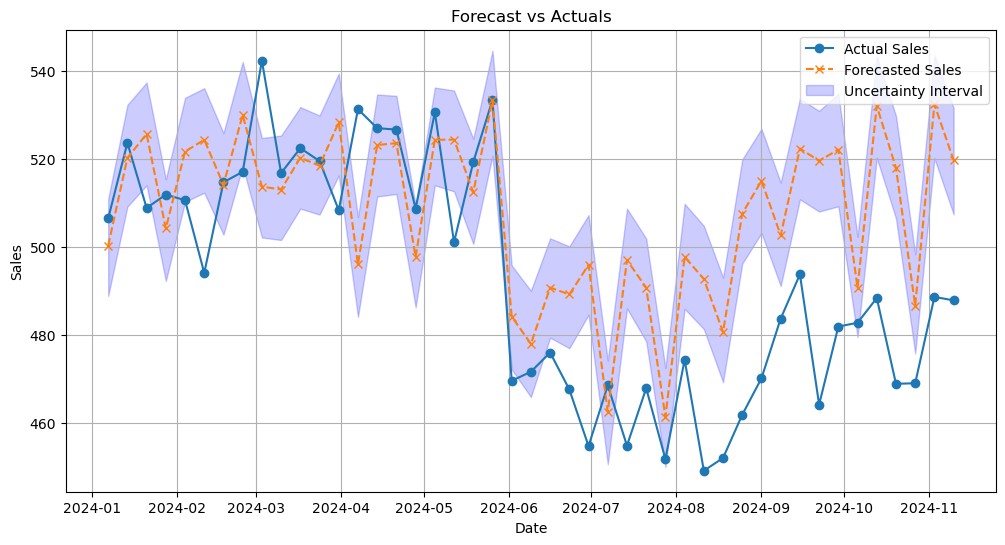

In [1]:
# Install Prophet if not already installed
try:
    from prophet import Prophet
except ImportError:
    print("Prophet is not installed. Installing now...")
    !pip install prophet

# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Generate Synthetic Data
np.random.seed(42)

# Create a date range
dates = pd.date_range(start="2022-01-01", periods=150, freq="W")  # Generate weekly data from 2022 to 2024

# Create synthetic sales data with seasonality and noise
sales = 500 + 20 * np.sin(2 * np.pi * dates.dayofyear / 365)  # Base seasonality
sales -= 30 * ((dates.month >= 6) & (dates.month <= 8))  # Decline in summer months
sales += np.random.normal(0, 10, len(dates))  # Add noise

# Create synthetic regressors
headcount = 50 + np.random.normal(0, 5, len(dates))
emails = 200 + 10 * np.random.normal(0, 5, len(dates))
marketing_spend = 30000 + 2000 * np.sin(2 * np.pi * dates.dayofyear / 365) + np.random.normal(0, 500, len(dates))
product_launches = np.random.poisson(1, len(dates))

# Add a dummy variable for summer months
summer_dummy = ((dates.month >= 6) & (dates.month <= 8)).astype(int)

# Combine into a DataFrame
df = pd.DataFrame({
    "ds": dates, 
    "y": sales, 
    "headcount": headcount, 
    "emails": emails, 
    "marketing_spend": marketing_spend, 
    "product_launches": product_launches,
    "summer": summer_dummy
})

# Add growth caps
df['cap'] = df['y'].max() + 100
df['floor'] = df['y'].min() - 50

# Visualize the synthetic sales data
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], label='Synthetic Sales')
plt.title("Synthetic Sales Data (With Summer Decline)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Step 2: Prepare Data
# Handle outliers in regressors
for column in ['headcount', 'emails', 'marketing_spend']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_limit, upper=upper_limit)

# Create individual scalers for each feature
scalers = {
    "headcount": StandardScaler(),
    "emails": StandardScaler(),
    "marketing_spend": StandardScaler(),
    "product_launches": StandardScaler()
}

# Apply scalers to each feature
for feature, scaler in scalers.items():
    df[feature] = scaler.fit_transform(df[[feature]])

# Step 3: Split Data into Train and Test
train_data = df[df['ds'] < '2024-01-01']  # Use 2022 and 2023 data for training
test_data = df[df['ds'] >= '2024-01-01']  # Use 2024 data for testing

# Step 4: Build the Prophet Model
model = Prophet(
    growth='logistic',
    seasonality_mode='additive',
    changepoint_prior_scale=0.05  # Smooth trend changes
)
model.add_regressor('headcount', prior_scale=0.5)
model.add_regressor('emails', prior_scale=0.5)
model.add_regressor('marketing_spend', prior_scale=0.5)
model.add_regressor('product_launches', prior_scale=0.5)
model.add_regressor('summer', prior_scale=0.1)  # Add summer dummy as a regressor
model.add_seasonality(name='quarterly', period=91.25, fourier_order=10)  # Fine-grained quarterly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Add monthly seasonality

# Fit the model on training data
model.fit(train_data)

# Step 5: Generate Future Predictions
future = model.make_future_dataframe(periods=len(test_data), freq='W')  # Extend for the test period

# Predicting realistic regressor values
for feature, scaler in scalers.items():
    if feature == 'marketing_spend':
        future[feature] = np.linspace(
            train_data[feature].mean(), test_data[feature].mean(), len(future)
        )
    else:
        future[feature] = scaler.transform(pd.DataFrame({feature: [train_data[feature].mean()] * len(future)}))

# Add summer dummy for future
future['summer'] = ((future['ds'].dt.month >= 6) & (future['ds'].dt.month <= 8)).astype(int)

# Adjust caps dynamically based on historical data
future['cap'] = df['cap'].max() + 100
future['floor'] = df['floor'].min() - 50

# Generate the forecast
forecast = model.predict(future)

# Step 6: Evaluate Model Performance
forecast_test = forecast[forecast['ds'].isin(test_data['ds'])]
mae = mean_absolute_error(test_data['y'], forecast_test['yhat'])
rmse = mean_squared_error(test_data['y'], forecast_test['yhat'], squared=False)
print(f"MAE: {mae}, RMSE: {rmse}")

# Step 7: Visualize Forecast vs Actuals
comparison = pd.merge(
    test_data[['ds', 'y']],
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='left'
)

plt.figure(figsize=(12, 6))
plt.plot(comparison['ds'], comparison['y'], label='Actual Sales', linestyle='-', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Forecasted Sales', linestyle='--', marker='x')
plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')
plt.title("Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()